In [1]:
from greensight.processing import load_sentinel_data_from_dir
from greensight.utils import DIR_DATA
import pandas as pd
import numpy as np
from datetime import datetime
import json

In [2]:
sentinel_data_path = DIR_DATA / "sentinel_data"
assert sentinel_data_path.is_dir()

In [23]:
year_paths = [path for path in sorted(list(sentinel_data_path.iterdir())) if "2016" not in path.name]
year_paths

[PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2018'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2019'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2020'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2021'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2022'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2023'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2024')]

In [24]:
year_path = year_paths[0]
year_path

PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017')

In [25]:
files = sorted([file for file in year_path.iterdir() if "mean" in file.stem and "S2" in file.stem])
files

[PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000000_0000000019_S2_mean.csv'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000020_0000000039_S2_mean.csv'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000040_0000000059_S2_mean.csv'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000060_0000000079_S2_mean.csv'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000080_0000000099_S2_mean.csv'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000100_0000000119_S2_mean.csv'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000120_0000000139_S2_mean.csv'),
 PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_dat

In [26]:
file = files[0]
file

PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017/feature_vectors__0000000000_0000000019_S2_mean.csv')

In [81]:

def load_and_process_csv(file):

    year = int(file.parent.name.split("_")[1])

    df = pd.read_csv(file)

    # set index
    df = df.set_index("LAD_CD")

    # drop unwanted columns
    df = df.drop(columns=["system:index", ".geo"])

    # check columns (month_band) for duplicates
    assert np.unique(df.columns).shape == df.columns.shape

    # get unique band identifiers
    band_inds = pd.unique(
        sorted([i.split("_")[1] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
    )

    # get month identifiers
    month_inds = pd.unique(
        [i.split("_")[0] for i in df.columns.unique() if i.split("_")[0].isnumeric()]
    )

    months = []
    inds = []
    for month in month_inds:
        # generate desired columns
        cols = [month + "_" + band for band in band_inds]

        # create df of desired columns
        df_month = df[cols].copy()

        # convert from a DataFrame of rows: shapes, columns: bands for a single month to a single row of rows: month, columns: (shape, band)
        row_month = df_month.stack().to_frame().T

        # create multi-index for the columns (shape, band)
        new_cols = [(a, b.split("_")[1]) for a, b in row_month.columns]
        row_month.columns = pd.MultiIndex.from_tuples(new_cols)

        # add to stack
        months.append(row_month)
        # add month name to index.
        inds.append(month)


    # combine rows
    df_month = pd.concat(months, axis=0)

    # fix index to month value
    df_month.index = np.array(inds).astype(int) + 1

    # format index
    df_month = df_month.sort_index()
    df_month.index.name = "date"
    df_month.index = [datetime(year, int(month), 1) for month in df_month.index]
    df_month.columns.names = ("shape", "band")

    assert df_month.shape == (len(month_inds), len(band_inds)*df.shape[0])

    # add greenbelt information from json dict.
    lookup_path = DIR_DATA / "id_lookup/id_lookup.json"
    with open(lookup_path, "r") as in_file:
        D_lookup = json.load(in_file)
    greenbelts = [D_lookup[code]["GB_Name"] for code, band in df_month.columns]

    # add greenbelts to column MultiIndex
    df_month.columns = pd.MultiIndex.from_tuples(
        [(gb, *cols) for gb, cols in zip(greenbelts, df_month.columns)]
    )
    df_month.columns.names = ("greenbelt", "shape", "band")

    return df_month

load_and_process_csv(files[2])

/tmp/ipykernel_66747/3066230134.py:17: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  band_inds = pd.unique(
/tmp/ipykernel_66747/3066230134.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  month_inds = pd.unique(


greenbelt  Cheltenham and Gloucester                                         \
shape                      E07000083                                          
band                              B1          B11          B12           B2   
2017-04-01                192.674705  2024.171386  1118.900155   299.657366   
2017-05-01                259.650231  2014.496588  1092.412112   355.987707   
2017-09-01                302.173372  2042.702977  1183.100950   404.828153   
2017-11-01                237.649897  1568.850263   883.426086   251.659292   
2017-12-01               1736.345336  1027.670097   642.105137  1553.621850   

greenbelt                                                                    \
shape                                                                         
band                 B3           B4           B5           B6           B7   
2017-04-01   661.219520   489.323348  1162.199456  3199.113707  3837.436694   
2017-05-01   700.790829   518.908399  1215.250468  3333.234706  4060.639448   
2017-09-01   702.682879   586.288324  1163.106197  2631.448563  3042.716669   
2017-11-01   489.596459   374.139883   952.626605  2242.261575  2536.350969   
2017-12-01  1558.003934  1485.240526  1898.599208  2597.285800  2696.807616   

greenbelt                ... Derby and Nottingham                          \
shape                    ...            E07000176                           
band                 B8  ...                  B12          B2          B3   
2017-04-01  4111.013746  ...                  NaN         NaN         NaN   
2017-05-01  4242.596568  ...           916.053298  365.482343  665.350195   
2017-09-01  3232.926193  ...          1109.269266  451.977359  653.196382   
2017-11-01  2809.095387  ...           795.089593  188.785150  375.650483   
2017-12-01  2868.371785  ...           729.510776  291.446478  443.235551   

greenbelt                                                                   \
shape                                                                        
band                B4           B5           B6           B7           B8   
2017-04-01         NaN          NaN          NaN          NaN          NaN   
2017-05-01  517.236550  1107.200120  3007.831895  3745.487257  3870.531275   
2017-09-01  627.300812  1054.100810  2020.726679  2315.724836  2441.681944   
2017-11-01  341.645544   814.389811  1815.835543  2044.495407  2235.974622   
2017-12-01  444.988603   875.249971  1722.192609  1915.375343  2068.475665   

greenbelt                             
shape                                 
band                B8A           B9  
2017-04-01          NaN          NaN  
2017-05-01  3947.637982  3981.238112  
2017-09-01  2520.695795  2516.972274  
2017-11-01  2232.041751  2266.442007  
2017-12-01  2087.040728  2022.980900  

[5 rows x 240 columns]

In [77]:
year_path

PosixPath('/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017')

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [110]:
df_all = []
for year_path in year_paths:
    year_files = [file for file in year_path.iterdir() if "mean" in file.stem and "S2" in file.stem]

    df_year = []
    for file in year_files:
    #     print(file)
        out = load_and_process_csv(file)
        df_year.append(out)
    df_year = pd.concat(df_year, axis=1)
    
    df_all.append(df_year)


In [117]:
df_all2 = [df[df_all[0].columns] for df in df_all]

In [118]:
df_all_combined = []

for df in df_all2:
    unique_columns = ~df.columns.duplicated(keep='first')

    df_unique = df.loc[:, unique_columns]

    df_all_combined.append(df_unique)

In [119]:
for df in df_all_combined:
    print(df.shape)

(9, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(12, 2160)
(10, 2160)


In [121]:
df_out = pd.concat(df_all_combined, axis=0)

In [109]:
df_combined

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                     B1          B11          B12          B2          B3   
2017-04-01       234.805820  1894.865456  1020.251965  311.276690  623.238776   
2017-05-01       216.930759  1909.530406   991.962320  302.160542  635.020438   
2017-06-01       252.662771  2188.810410  1161.614115  340.702544  724.435485   
2017-07-01       300.029123  2017.795291  1048.994736  363.510906  677.887598   
2017-08-01              NaN          NaN          NaN         NaN         NaN   
...                     ...          ...          ...         ...         ...   
2024-06-01       395.767116  2035.439397  1110.330183  454.728518  773.270753   
2024-07-01       293.769673  2288.305522  1249.925666  421.786959  735.594935   
2024-08-01       478.499272  2250.335482  1255.271394  531.902502  793.528614   
2024-09-01       387.997932  2132.064292  1260.179600  507.951894  759.827593   
2024-10-01       342.644046  1924.061259  1071.607682  388.586222  660.778449   

greenbelt                                                                   \
shape                                                                        
band                B4           B5           B6           B7           B8   
2017-04-01  422.891561  1094.207824  3108.089837  3732.298612  3999.326764   
2017-05-01  417.478271  1125.957264  3312.175030  4058.373258  4197.780260   
2017-06-01  551.242964  1301.592959  3402.514986  4113.497425  4226.873012   
2017-07-01  482.459567  1183.826676  3112.659109  3686.713608  3856.484979   
2017-08-01         NaN          NaN          NaN          NaN          NaN   
...                ...          ...          ...          ...          ...   
2024-06-01  560.437081  1284.787768  3283.141528  3997.971013  4233.961275   
2024-07-01  572.059202  1267.901809  2969.523933  3622.844338  3733.505384   
2024-08-01  680.000191  1275.776706  2751.885949  3273.287014  3445.482901   
2024-09-01  615.935952  1222.373488  2649.960805  3127.621285  3371.289760   
2024-10-01  492.556606  1098.341848  2605.414783  3036.303431  3245.904375   

greenbelt   ...         York                                                   \
shape       ...    E07000167                                                    
band        ...          B12          B2          B3          B4           B5   
2017-04-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-05-01  ...  1182.111125  343.276927  627.370944  507.285913  1045.571895   
2017-06-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-07-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-08-01  ...          NaN         NaN         NaN         NaN          NaN   
...         ...          ...         ...         ...         ...          ...   
2024-06-01  ...  1428.124555  520.649828  833.662868  730.455500  1356.551093   
2024-07-01  ...  1348.621849  449.142528  756.872421  695.951066  1293.446824   
2024-08-01  ...  1337.656668  628.183908  850.845034  855.063460  1321.169856   
2024-09-01  ...  1478.087273  473.549769  692.731994  710.134110  1145.907284   
2024-10-01  ...  1367.883743  578.310517  805.934190  751.391124  1207.402365   

greenbelt                                                                    
shape                                                                        
band                 B6           B7           B8          B8A           B9  
2017-04-01          NaN          NaN          NaN          NaN          NaN  
2017-05-01  2744.188250  3335.098446  3509.033587  3544.669321  3575.736009  
2017-06-01          NaN          NaN          NaN          NaN          NaN  
2017-07-01          NaN          NaN          NaN          NaN          NaN  
2017-08-01          NaN          NaN          NaN          NaN          NaN  
...          

greenbelt,Bath and Bristol
shape,E06000022
band,B1
2018-01-01,225.851512
2018-02-01,254.091559
2018-03-01,439.485245
2018-04-01,229.929276
2018-05-01,258.668579
2018-06-01,260.490039
2018-07-01,500.887774
2018-08-01,810.483679


In [103]:
a = df_all2[0].columns[0]
a

('Bath and Bristol', 'E06000022', 'B1')

In [15]:
combined_dfs = []
for path in paths:
    files = sorted([file for file  in path.iterdir() if "S2" in file.name and "mean" in file.name])

    dfs = [load_and_process_csv(file) for file in files]

    combined_df = pd.concat(dfs, axis=1)

    combined_dfs.append(combined_df)
    break

/tmp/ipykernel_63777/1266770564.py:12: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  band_inds = pd.unique(
/tmp/ipykernel_63777/1266770564.py:17: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  month_inds = pd.unique(
/tmp/ipykernel_63777/1266770564.py:54: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_month = df_month.groupby(level=[0, 1], axis=1).mean()
/tmp/ipykernel_63777/1266770564.py:12: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  band_inds = pd.unique(
/tmp/ipykernel_63777/1266770564.py:17: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated an

In [16]:
set([c[0] for c in combined_df.columns])

{'Bath and Bristol',
 'Birmingham',
 'Blackpool',
 'Burton-upon-Trent and Swadlincote',
 'Cambridge',
 'Carnforth, Lancaster and Morecambe',
 'Cheltenham and Gloucester',
 'Derby and Nottingham',
 'London',
 'Merseyside and Greater Manchester',
 'Oxford',
 'South West Hampshire',
 'South and West Yorkshire',
 'Stoke-on-Trent',
 'Tyne and Wear',
 'York'}

In [17]:
combined_df.columns[combined_df.columns.duplicated()]

MultiIndex([('Derby and Nottingham', 'E07000039',  'B1'),
            ('Derby and Nottingham', 'E07000039', 'B11'),
            ('Derby and Nottingham', 'E07000039', 'B12'),
            ('Derby and Nottingham', 'E07000039',  'B2'),
            ('Derby and Nottingham', 'E07000039',  'B3'),
            ('Derby and Nottingham', 'E07000039',  'B4'),
            ('Derby and Nottingham', 'E07000039',  'B5'),
            ('Derby and Nottingham', 'E07000039',  'B6'),
            ('Derby and Nottingham', 'E07000039',  'B7'),
            ('Derby and Nottingham', 'E07000039',  'B8'),
            ('Derby and Nottingham', 'E07000039', 'B8A'),
            ('Derby and Nottingham', 'E07000039',  'B9'),
            (      'Stoke-on-Trent', 'E06000049',  'B1'),
            (      'Stoke-on-Trent', 'E06000049', 'B11'),
            (      'Stoke-on-Trent', 'E06000049', 'B12'),
            (      'Stoke-on-Trent', 'E06000049',  'B2'),
            (      'Stoke-on-Trent', 'E06000049',  'B3'),
            ( 

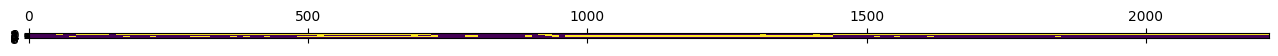

In [38]:
import matplotlib.pyplot as plt
plt.matshow(combined_df.isna())

In [31]:
np.logical_not(combined_df.columns.duplicated()).sum()

np.int64(2160)

In [34]:
combined_df[(combined_df.columns[np.logical_not(combined_df.columns.duplicated())])].shape

(9, 2220)

In [28]:
combined_df[combined_df.columns[np.logical_not(combined_df.columns.duplicated())]]

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                     B1          B11          B12          B2          B3   
2017-04-01       234.805820  1894.865456  1020.251965  311.276690  623.238776   
2017-05-01       216.930759  1909.530406   991.962320  302.160542  635.020438   
2017-06-01       252.662771  2188.810410  1161.614115  340.702544  724.435485   
2017-07-01       300.029123  2017.795291  1048.994736  363.510906  677.887598   
2017-08-01              NaN          NaN          NaN         NaN         NaN   
2017-09-01       286.098908  1902.942489  1026.107571  389.650341  682.130256   
2017-10-01       254.344848  1483.089540   793.581387  302.767862  528.551869   
2017-11-01       197.450980  1366.747610   740.642347  218.553386  432.857292   
2017-12-01       367.138821  1284.350454   752.613559  518.289490  671.465516   

greenbelt                                                                   \
shape                                                                        
band                B4           B5           B6           B7           B8   
2017-04-01  422.891561  1094.207824  3108.089837  3732.298612  3999.326764   
2017-05-01  417.478271  1125.957264  3312.175030  4058.373258  4197.780260   
2017-06-01  551.242964  1301.592959  3402.514986  4113.497425  4226.873012   
2017-07-01  482.459567  1183.826676  3112.659109  3686.713608  3856.484979   
2017-08-01         NaN          NaN          NaN          NaN          NaN   
2017-09-01  500.063075  1128.134858  2881.094629  3397.571184  3562.220667   
2017-10-01  336.124750   857.395147  2323.048732  2715.312746  2843.160729   
2017-11-01  281.527530   857.074685  2171.410421  2489.864531  2744.031086   
2017-12-01  572.528598  1079.859141  2117.250516  2358.803149  2559.262116   

greenbelt   ...         York                                                   \
shape       ...    E07000167                                                    
band        ...          B12          B2          B3          B4           B5   
2017-04-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-05-01  ...  1182.111125  343.276927  627.370944  507.285913  1045.571895   
2017-06-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-07-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-08-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-09-01  ...  1328.449507  421.273293  661.441980  679.892865  1131.410166   
2017-10-01  ...  1366.286631  401.465677  647.281463  634.869908  1086.513093   
2017-11-01  ...  1028.647126  287.045621  468.697317  407.219918   880.503906   
2017-12-01  ...   867.225189  819.237543  846.076542  825.747386  1272.058508   

greenbelt                                                                    
shape                                                                        
band                 B6           B7           B8          B8A           B9  
2017-04-01          NaN          NaN          NaN          NaN          NaN  
2017-05-01  2744.188250  3335.098446  3509.033587  3544.669321  3575.736009  
2017-06-01          NaN          NaN          NaN          NaN          NaN  
2017-07-01          NaN          NaN          NaN          NaN          NaN  
2017-08-01          NaN          NaN          NaN          NaN          NaN  
2017-09-01  2079.496653  2374.444885  2532.717403  2612.534831  2605.930166  
2017-10-01  1963.043989  2211.168496  2298.598251  2425.760254  2385.374373  
2017-11-01  1760.808112  1977.601125  2191.627840  2198.734798  2293.354206  
2017-12-01  1943.635583  2102.412827  2272.127796  2286.606633  2120.460910  

[9 rows x 2220 columns]

In [20]:
combined_df[combined_df.columns[combined_df.columns.duplicated()]]

greenbelt  Derby and Nottingham                                        \
shape                 E07000039                                         
band                         B1          B1          B11          B11   
2017-04-01           229.318720   23.570755  1563.772374   660.809339   
2017-05-01           142.864610  401.776601  2034.350886  1535.581323   
2017-06-01                  NaN         NaN          NaN          NaN   
2017-07-01                  NaN         NaN          NaN          NaN   
2017-08-01           199.866040         NaN  2047.126174          NaN   
2017-09-01           127.790271  298.092137  1944.330996  1919.889107   
2017-10-01                  NaN         NaN          NaN          NaN   
2017-11-01           176.005978  193.688265  1484.016012  1474.705436   
2017-12-01           311.261201  230.084241  1163.255542  1146.180883   

greenbelt                                                                 \
shape                                                                      
band                B12          B12          B2          B2          B3   
2017-04-01   830.724151   399.683531  291.208785   85.556198  561.235869   
2017-05-01  1056.809176   874.929775  294.175103  474.326406  643.530365   
2017-06-01          NaN          NaN         NaN         NaN         NaN   
2017-07-01          NaN          NaN         NaN         NaN         NaN   
2017-08-01  1078.123239          NaN  501.725092         NaN  815.345015   
2017-09-01  1044.442776  1202.554517  290.231510  429.679119  610.697512   
2017-10-01          NaN          NaN         NaN         NaN         NaN   
2017-11-01   814.681677   853.631677  191.902606  231.646671  424.665286   
2017-12-01   708.070672   697.099848  365.473069  328.816751  481.818286   

greenbelt               ...         York                            \
shape                   ...    E07000169                             
band                B3  ...           B6           B6           B7   
2017-04-01  265.689785  ...  2757.387755          NaN  3349.636814   
2017-05-01  735.499679  ...  2707.546244  2775.966841  3375.635916   
2017-06-01         NaN  ...          NaN          NaN          NaN   
2017-07-01         NaN  ...          NaN          NaN          NaN   
2017-08-01         NaN  ...          NaN          NaN          NaN   
2017-09-01  668.458247  ...  2075.060093  2092.613066  2358.482730   
2017-10-01         NaN  ...  1906.187641  2125.781156  2118.389113   
2017-11-01  452.941578  ...  1796.279681  1651.506600  1993.536835   
2017-12-01  461.793369  ...  1656.650516  1723.333445  1818.560735   

greenbelt                                                                    \
shape                                                                         
band                 B7           B8           B8          B8A          B8A   
2017-04-01          NaN  3606.364054          NaN  3604.038664          NaN   
2017-05-01  3527.269733  3500.239578  3684.038486  3558.559980  3747.990012   
2017-06-01          NaN          NaN          NaN          NaN          NaN   
2017-07-01          NaN          NaN          NaN          NaN          NaN   
2017-08-01          NaN          NaN          NaN          NaN          NaN   
2017-09-01  2392.646560  2481.747799  2527.692846  2553.180234  2616.737171   
2017-10-01  2361.477492  2259.729343  2511.461338  2293.283699  2575.172202   
2017-11-01  1843.277388  2174.403135  2031.525848  2174.088259  2044.235817   
2017-12-01  1847.320869  1967.524109  2007.075160  1970.423382  1998.562940   

greenbelt                             
shape                                 
band                 B9           B9  
2017-04-01  3642.874661          NaN  
2017-05-01  3592.935706  3788.890053  
2017-06-01          NaN          NaN  
2017-07-01          NaN          NaN  
2017-08-01          NaN          NaN  
2017-09-01  2535.355688  2604.069038  
2017-10-01  2243.051610  2557.321368  
2017-11-01  2261.199553  2159.

In [66]:
[c for c  in combined_dfs[4].columns if c not in combined_dfs[0].columns]

/tmp/ipykernel_45914/2117928682.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  [c for c  in combined_dfs[4].columns if c not in combined_dfs[0].columns]


[]

In [67]:
len(pd.unique(combined_dfs[4].columns))

2160

In [68]:
len(pd.unique(combined_dfs[0].columns))

2160

In [64]:

combined_dfs[4].drop(columns = ["ndvi"], level="band")

KeyError: "['ndvi'] not found in axis"

In [13]:
combined_dfs[0]

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                     B1          B11          B12          B2          B3   
2017-04-01       234.805820  1894.865456  1020.251965  311.276690  623.238776   
2017-05-01       216.930759  1909.530406   991.962320  302.160542  635.020438   
2017-06-01       252.662771  2188.810410  1161.614115  340.702544  724.435485   
2017-07-01       300.029123  2017.795291  1048.994736  363.510906  677.887598   
2017-08-01              NaN          NaN          NaN         NaN         NaN   
2017-09-01       286.098908  1902.942489  1026.107571  389.650341  682.130256   
2017-10-01       254.344848  1483.089540   793.581387  302.767862  528.551869   
2017-11-01       197.450980  1366.747610   740.642347  218.553386  432.857292   
2017-12-01       367.138821  1284.350454   752.613559  518.289490  671.465516   

greenbelt                                                                   \
shape                                                                        
band                B4           B5           B6           B7           B8   
2017-04-01  422.891561  1094.207824  3108.089837  3732.298612  3999.326764   
2017-05-01  417.478271  1125.957264  3312.175030  4058.373258  4197.780260   
2017-06-01  551.242964  1301.592959  3402.514986  4113.497425  4226.873012   
2017-07-01  482.459567  1183.826676  3112.659109  3686.713608  3856.484979   
2017-08-01         NaN          NaN          NaN          NaN          NaN   
2017-09-01  500.063075  1128.134858  2881.094629  3397.571184  3562.220667   
2017-10-01  336.124750   857.395147  2323.048732  2715.312746  2843.160729   
2017-11-01  281.527530   857.074685  2171.410421  2489.864531  2744.031086   
2017-12-01  572.528598  1079.859141  2117.250516  2358.803149  2559.262116   

greenbelt   ...         York                                                   \
shape       ...    E07000169                                                    
band        ...          B12          B2          B3          B4           B5   
2017-04-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-05-01  ...  1024.786689  298.379946  572.363760  449.615250   972.585315   
2017-06-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-07-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-08-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-09-01  ...  1324.061547  426.264308  670.043047  697.440997  1137.463257   
2017-10-01  ...  1386.025424  476.058408  765.496934  730.497923  1210.486489   
2017-11-01  ...  1004.742482  310.939671  472.568256  427.922748   857.274163   
2017-12-01  ...   893.603490  806.291648  790.529887  783.050067  1154.471594   

greenbelt                                                                    
shape                                                                        
band                 B6           B7           B8          B8A           B9  
2017-04-01          NaN          NaN          NaN          NaN          NaN  
2017-05-01  2775.966841  3527.269733  3684.038486  3747.990012  3788.890053  
2017-06-01          NaN          NaN          NaN          NaN          NaN  
2017-07-01          NaN          NaN          NaN          NaN          NaN  
2017-08-01          NaN          NaN          NaN          NaN          NaN  
2017-09-01  2092.613066  2392.646560  2527.692846  2616.737171  2604.069038  
2017-10-01  2125.781156  2361.477492  2511.461338  2575.172202  2557.321368  
2017-11-01  1651.506600  1843.277388  2031.525848  2044.235817  2159.602540  
2017-12-01  1723.333445  1847.320869  2007.075160  1998.562940  2012.749134  

[9 rows x 2220 columns]

In [22]:
combined_dfs[0]

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                     B1          B11          B12          B2          B3   
2017-04-01       234.805820  1894.865456  1020.251965  311.276690  623.238776   
2017-05-01       216.930759  1909.530406   991.962320  302.160542  635.020438   
2017-06-01       252.662771  2188.810410  1161.614115  340.702544  724.435485   
2017-07-01       300.029123  2017.795291  1048.994736  363.510906  677.887598   
2017-08-01              NaN          NaN          NaN         NaN         NaN   
2017-09-01       286.098908  1902.942489  1026.107571  389.650341  682.130256   
2017-10-01       254.344848  1483.089540   793.581387  302.767862  528.551869   
2017-11-01       197.450980  1366.747610   740.642347  218.553386  432.857292   
2017-12-01       367.138821  1284.350454   752.613559  518.289490  671.465516   

greenbelt                                                                   \
shape                                                                        
band                B4           B5           B6           B7           B8   
2017-04-01  422.891561  1094.207824  3108.089837  3732.298612  3999.326764   
2017-05-01  417.478271  1125.957264  3312.175030  4058.373258  4197.780260   
2017-06-01  551.242964  1301.592959  3402.514986  4113.497425  4226.873012   
2017-07-01  482.459567  1183.826676  3112.659109  3686.713608  3856.484979   
2017-08-01         NaN          NaN          NaN          NaN          NaN   
2017-09-01  500.063075  1128.134858  2881.094629  3397.571184  3562.220667   
2017-10-01  336.124750   857.395147  2323.048732  2715.312746  2843.160729   
2017-11-01  281.527530   857.074685  2171.410421  2489.864531  2744.031086   
2017-12-01  572.528598  1079.859141  2117.250516  2358.803149  2559.262116   

greenbelt   ...         York                                                   \
shape       ...    E07000169                                                    
band        ...          B12          B2          B3          B4           B5   
2017-04-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-05-01  ...  1024.786689  298.379946  572.363760  449.615250   972.585315   
2017-06-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-07-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-08-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-09-01  ...  1324.061547  426.264308  670.043047  697.440997  1137.463257   
2017-10-01  ...  1386.025424  476.058408  765.496934  730.497923  1210.486489   
2017-11-01  ...  1004.742482  310.939671  472.568256  427.922748   857.274163   
2017-12-01  ...   893.603490  806.291648  790.529887  783.050067  1154.471594   

greenbelt                                                                    
shape                                                                        
band                 B6           B7           B8          B8A           B9  
2017-04-01          NaN          NaN          NaN          NaN          NaN  
2017-05-01  2775.966841  3527.269733  3684.038486  3747.990012  3788.890053  
2017-06-01          NaN          NaN          NaN          NaN          NaN  
2017-07-01          NaN          NaN          NaN          NaN          NaN  
2017-08-01          NaN          NaN          NaN          NaN          NaN  
2017-09-01  2092.613066  2392.646560  2527.692846  2616.737171  2604.069038  
2017-10-01  2125.781156  2361.477492  2511.461338  2575.172202  2557.321368  
2017-11-01  1651.506600  1843.277388  2031.525848  2044.235817  2159.602540  
2017-12-01  1723.333445  1847.320869  2007.075160  1998.562940  2012.749134  

[9 rows x 2220 columns]

In [62]:
for n in range(len(combined_dfs)):
    print(combined_dfs[n].index.min())
    print(combined_dfs[n].index.max())
    print(combined_dfs[n].index.dtype)
    print(combined_dfs[n].shape)
    print(np.shape(combined_dfs[n].columns))
    print()

2017-04-01 00:00:00
2017-12-01 00:00:00
datetime64[ns]
(9, 2220)
(2220,)

2018-01-01 00:00:00
2018-12-01 00:00:00
datetime64[ns]
(12, 2220)
(2220,)

2019-01-01 00:00:00
2019-12-01 00:00:00
datetime64[ns]
(12, 2220)
(2220,)

2020-01-01 00:00:00
2020-12-01 00:00:00
datetime64[ns]
(12, 2220)
(2220,)

2021-01-01 00:00:00
2021-12-01 00:00:00
datetime64[ns]
(12, 2340)
(2340,)

2022-01-01 00:00:00
2022-12-01 00:00:00
datetime64[ns]
(12, 2220)
(2220,)

2023-01-01 00:00:00
2023-12-01 00:00:00
datetime64[ns]
(12, 2220)
(2220,)

2024-01-01 00:00:00
2024-10-01 00:00:00
datetime64[ns]
(10, 2220)
(2220,)



In [61]:
[i for i in df.columns if i not in combined_dfs[0].columns]

/tmp/ipykernel_45914/2825037111.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  [i for i in df.columns if i not in combined_dfs[0].columns]


[('Stoke-on-Trent', 'E06000021', 'ndvi'),
 ('Tyne and Wear', 'E06000047', 'ndvi'),
 ('Tyne and Wear', 'E06000057', 'ndvi'),
 ('Stoke-on-Trent', 'E07000197', 'ndvi'),
 ('Stoke-on-Trent', 'E07000198', 'ndvi'),
 ('Tyne and Wear', 'E08000021', 'ndvi'),
 ('Tyne and Wear', 'E08000022', 'ndvi'),
 ('Tyne and Wear', 'E08000023', 'ndvi'),
 ('Tyne and Wear', 'E08000024', 'ndvi'),
 ('Tyne and Wear', 'E08000037', 'ndvi')]

In [45]:
df.columns[0]

('Bath and Bristol', 'E06000022', 'B1')

In [42]:
[i[0] for i in df.columns if "tyne" in i[0].lower()]

[('Tyne and Wear', 'E06000047', 'B1'),
 ('Tyne and Wear', 'E06000047', 'B11'),
 ('Tyne and Wear', 'E06000047', 'B12'),
 ('Tyne and Wear', 'E06000047', 'B2'),
 ('Tyne and Wear', 'E06000047', 'B3'),
 ('Tyne and Wear', 'E06000047', 'B4'),
 ('Tyne and Wear', 'E06000047', 'B5'),
 ('Tyne and Wear', 'E06000047', 'B6'),
 ('Tyne and Wear', 'E06000047', 'B7'),
 ('Tyne and Wear', 'E06000047', 'B8'),
 ('Tyne and Wear', 'E06000047', 'B8A'),
 ('Tyne and Wear', 'E06000047', 'B9'),
 ('Tyne and Wear', 'E06000057', 'B1'),
 ('Tyne and Wear', 'E06000057', 'B11'),
 ('Tyne and Wear', 'E06000057', 'B12'),
 ('Tyne and Wear', 'E06000057', 'B2'),
 ('Tyne and Wear', 'E06000057', 'B3'),
 ('Tyne and Wear', 'E06000057', 'B4'),
 ('Tyne and Wear', 'E06000057', 'B5'),
 ('Tyne and Wear', 'E06000057', 'B6'),
 ('Tyne and Wear', 'E06000057', 'B7'),
 ('Tyne and Wear', 'E06000057', 'B8'),
 ('Tyne and Wear', 'E06000057', 'B8A'),
 ('Tyne and Wear', 'E06000057', 'B9'),
 ('Tyne and Wear', 'E08000021', 'B1'),
 ('Tyne and Wear', 

In [37]:
for df in combined_dfs:
    try:
        print((df.columns == combined_dfs[0].columns).all())
    except:
        break

True
True
True
True


In [39]:
combined_dfs[0]

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                     B1          B11          B12          B2          B3   
2017-04-01       234.805820  1894.865456  1020.251965  311.276690  623.238776   
2017-05-01       216.930759  1909.530406   991.962320  302.160542  635.020438   
2017-06-01       252.662771  2188.810410  1161.614115  340.702544  724.435485   
2017-07-01       300.029123  2017.795291  1048.994736  363.510906  677.887598   
2017-08-01              NaN          NaN          NaN         NaN         NaN   
2017-09-01       286.098908  1902.942489  1026.107571  389.650341  682.130256   
2017-10-01       254.344848  1483.089540   793.581387  302.767862  528.551869   
2017-11-01       197.450980  1366.747610   740.642347  218.553386  432.857292   
2017-12-01       367.138821  1284.350454   752.613559  518.289490  671.465516   

greenbelt                                                                   \
shape                                                                        
band                B4           B5           B6           B7           B8   
2017-04-01  422.891561  1094.207824  3108.089837  3732.298612  3999.326764   
2017-05-01  417.478271  1125.957264  3312.175030  4058.373258  4197.780260   
2017-06-01  551.242964  1301.592959  3402.514986  4113.497425  4226.873012   
2017-07-01  482.459567  1183.826676  3112.659109  3686.713608  3856.484979   
2017-08-01         NaN          NaN          NaN          NaN          NaN   
2017-09-01  500.063075  1128.134858  2881.094629  3397.571184  3562.220667   
2017-10-01  336.124750   857.395147  2323.048732  2715.312746  2843.160729   
2017-11-01  281.527530   857.074685  2171.410421  2489.864531  2744.031086   
2017-12-01  572.528598  1079.859141  2117.250516  2358.803149  2559.262116   

greenbelt   ...         York                                                   \
shape       ...    E07000169                                                    
band        ...          B12          B2          B3          B4           B5   
2017-04-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-05-01  ...  1024.786689  298.379946  572.363760  449.615250   972.585315   
2017-06-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-07-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-08-01  ...          NaN         NaN         NaN         NaN          NaN   
2017-09-01  ...  1324.061547  426.264308  670.043047  697.440997  1137.463257   
2017-10-01  ...  1386.025424  476.058408  765.496934  730.497923  1210.486489   
2017-11-01  ...  1004.742482  310.939671  472.568256  427.922748   857.274163   
2017-12-01  ...   893.603490  806.291648  790.529887  783.050067  1154.471594   

greenbelt                                                                    
shape                                                                        
band                 B6           B7           B8          B8A           B9  
2017-04-01          NaN          NaN          NaN          NaN          NaN  
2017-05-01  2775.966841  3527.269733  3684.038486  3747.990012  3788.890053  
2017-06-01          NaN          NaN          NaN          NaN          NaN  
2017-07-01          NaN          NaN          NaN          NaN          NaN  
2017-08-01          NaN          NaN          NaN          NaN          NaN  
2017-09-01  2092.613066  2392.646560  2527.692846  2616.737171  2604.069038  
2017-10-01  2125.781156  2361.477492  2511.461338  2575.172202  2557.321368  
2017-11-01  1651.506600  1843.277388  2031.525848  2044.235817  2159.602540  
2017-12-01  1723.333445  1847.320869  2007.075160  1998.562940  2012.749134  

[9 rows x 2220 columns]

In [38]:
df

greenbelt  Bath and Bristol                                                    \
shape             E06000022                                                     
band                     B1          B11          B12          B2          B3   
2021-01-01       839.131617  1168.836862   674.972437  898.987838  969.082330   
2021-02-01       200.038993  1704.531980  1016.965660  327.091195  562.647333   
2021-03-01       405.317004  1715.638745  1017.009993  495.667424  688.303927   
2021-04-01       425.161481  2057.796503  1212.922346  472.081649  739.751676   
2021-05-01       468.865326  1831.997982   980.645001  476.309387  765.961161   
2021-06-01       378.443181  1990.452467  1086.260018  447.975243  747.086968   
2021-07-01       212.883708  2180.315205  1152.769070  318.885507  662.165703   
2021-08-01       605.624119  1985.098397  1055.245346  633.436904  824.257528   
2021-09-01       407.624051  2185.403219  1265.690131  481.056409  718.299386   
2021-10-01       266.672990  1791.621850   976.706063  338.173778  630.830360   
2021-11-01       174.833362  1635.162315   952.726578  335.578681  545.064220   
2021-12-01       266.368821  1581.342531   916.337210  378.314884  551.113594   

greenbelt                                                                   \
shape                                                                        
band                B4           B5           B6           B7           B8   
2021-01-01  831.856901  1321.427323  2229.592107  2486.348150  2670.076025   
2021-02-01  502.637727  1035.262131  2108.689360  2439.320034  2663.252293   
2021-03-01  578.576135  1079.426041  2274.986796  2674.361080  2911.035639   
2021-04-01  612.454167  1219.509694  2786.558251  3308.804080  3614.698348   
2021-05-01  511.936613  1225.098823  3214.155558  3864.439220  4088.590644   
2021-06-01  531.053685  1196.050874  3181.161310  3940.885305  4144.253694   
2021-07-01  517.484237  1193.417375  3002.744893  3642.878010  3785.947512   
2021-08-01  586.835132  1161.040288  2912.007714  3538.612853  3723.891909   
2021-09-01  564.528237  1121.199291  2590.848069  3102.353532  3207.179256   
2021-10-01  468.601123  1062.135785  2581.249109  3006.346481  3240.987576   
2021-11-01  427.444317   950.807996  2155.078774  2520.460366  2758.543086   
2021-12-01  438.795151   965.043851  2095.224142  2425.911058  2710.970859   

greenbelt   ...         York                                         \
shape       ...    E07000169                                          
band        ...          B12           B2           B3           B4   
2021-01-01  ...   629.376908   687.276088   755.342450   628.703787   
2021-02-01  ...  1185.632805  1129.667958  1328.684512  1374.090110   
2021-03-01  ...  1590.070783   642.265109   881.651306   878.196839   
2021-04-01  ...  1554.794329   535.270534   784.424275   780.005489   
2021-05-01  ...   995.379842   513.709731   722.048983   554.001281   
2021-06-01  ...  1191.249961   546.273945   791.127880   614.020667   
2021-07-01  ...  1100.316803   478.052865   779.033400   677.598517   
2021-08-01  ...  1321.511750   939.656039  1043.220547  1078.385903   
2021-09-01  ...  1804.479790   674.599764   939.823067   993.351846   
2021-10-01  ...   973.792870   334.238217   586.315476   576.341817   
2021-11-01  ...  1038.423351   398.878562   597.638952   527.938417   
2021-12-01  ...   923.040661   386.842680   508.153852   447.167509   

greenbelt                                                                    \
shape                                                                         
band                 B5           B6           B7           B8          B8A   
2021-01-01  1099.820307  1907.166906  2102.678457  2261.187578  2251.986013   
2021-02-01  1843.586330  2520.874054  2717.486861  2924.958670  2867.612481   
2021-03-01  1304.870845  2268.638872  2610.399147  2776.246341  2783.552280   
2021-04-01  1252.086505  2464.566424  2908.728139  3140.777973  3134.4370

In [31]:
df_all = pd.concat(combined_dfs, axis = 0)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

TypeError: Invalid shape (2220,) for image data

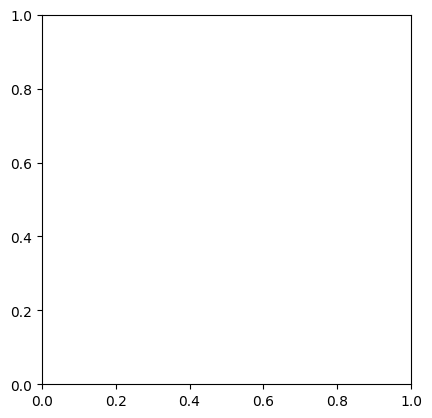

In [30]:
import matplotlib.pyplot as plt
 
for df in combined_dfs:
    plt.imshow(df.columns.duplicated())